In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!cp drive/My\ Drive/UNIBO/Teaching/CV/cvlabs/lab3/lab3_images.zip ./
!unzip lab3_images.zip

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

## World Reference Frame

**Different calibration images lead to different World Reference Frames**.
You can actually do your calibration by **moving the chessboard**, but the software sees those transformations as if you were **moving the camera**.

**Of course you can also move the camera to acquire the various calibration images.**

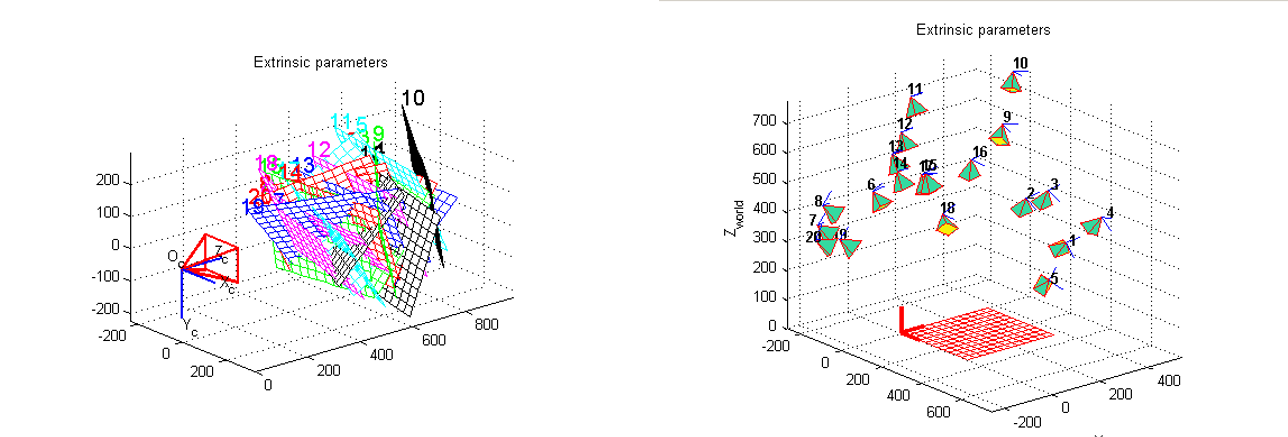

The position of the origin of the WRF on the chessboard is arbitrary, and different packages define it differently.

OpenCV > 2.2 places it so that:
* the **origin** lays on the **first row or column starting and ending with black squares**
* the resulting **z axis** in a **right-handed** reference frame **points away from the camera**.

Note that, in OpenCV to define the chessboard we use **the number of internal corners**.

In [ ]:
dirname = "chessboards/"
img_names = [dirname + str(i) + ".jpg" for i in range(13)]
print(img_names[0])

img = cv2.imread(img_names[0],cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.show()

In [ ]:
pattern_size = (8,5) # number of inner corner, (columns, rows) for OpenCV
square_size = 26.5 #mm

# Use "found, corners = cv2.findChessboardCorners(img, pattern_size)" to detect corner in an image.
# "found" will be true if and only if all the 8x5 (40) corners will be detected in the image. 
# If the image is too dark or too bright the algorithm may fail to detect corners. 
found, corners = cv2.findChessboardCorners(img, pattern_size)
print("Found: ", found)

In [ ]:
# Do cornerSubPix only if chessboard found is True
if found:
    #Refining corner position to subpixel iteratively until criteria max_count=30 or criteria_eps_error=1 is satisfied
    term = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_COUNT, 30, 1)
    #Image Corners 
    cv2.cornerSubPix(img, corners, (5, 5), (-1, -1), term)

In [ ]:
# visualize the founded corners
vis = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
cv2.drawChessboardCorners(vis, pattern_size, corners, found)
plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
#Let us create the 3D coordinate for each corner of the chessboard. 
indices = np.indices(pattern_size, dtype=np.float32)
print(indices)
#Since we know that the distance between the corners is exactly 26.5mm we have 
# to multiply these indices by square_size to get the real 3D x,y coordinates
indices *= square_size
print("Shape of indices: " , indices.shape)
print(indices)

In [ ]:
#We need a list of 3D-2D pairs. Since 2D points are expressed by OpenCV 
#convention (x, y), we need to do the same for the 3D points
print(indices.shape)
coords_3D = np.transpose(indices, [2, 1, 0])
print("Transpose shape: " , coords_3D.shape)
coords_3D = coords_3D.reshape(-1, 2)
print(coords_3D.shape)

#Planar assumption (z=0) we need to add 0 as 3rd coordinate 
pattern_points = np.concatenate([coords_3D, np.zeros([coords_3D.shape[0], 1], dtype=np.float32)], axis=-1)
print(pattern_points.shape)
print(pattern_points)

In [ ]:
#The process must be repeated for each image aquisistion of the chessboard
def processImage(filename):
    print('processing {}'.format(filename))
    img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    # Check image loaded correctly
    if img is None:
        print("Failed to load", filename)
        return None
    # Finding corners
    found, corners = cv2.findChessboardCorners(img, pattern_size)
    if found:
        # Refining corner position
        term = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_COUNT, 5, 1)
        cv2.cornerSubPix(img, corners, (5, 5), (-1, -1), term)
    else:
        print('chessboard not found')
        return None
    print('OK')
    return corners.reshape(-1, 2)

In [ ]:
corners_list = [processImage(fn) for fn in img_names]

pattern_points_list = [pattern_points for i in range(len(img_names))]

**cv2.calibrateCamera()** returns:


* RMS (Root Mean Square Error): **Reprojection error in pixel** using the estimated camera parameters. The lower it is the better calibration you obtain. Usually it should be in a range **between 0.1 and 1** in good calibrations. If it is much larger than 1 you did some mistakes during the calibration process.

* camera_matrix: **Intrinsics parameters** of the camera expressed as 3x3 matrix

* dist_coefs: **lens distorsion** coefficents expressed as 1x5 array.

* rvecs: **rotations** of the cameras **for each chessboard image**. It is an array of dimension Nx3 where N are the number of images where you found the chessboard during calibration while 3 are the 3 DOF of the rotations.

* tvecs: **translations** of the cameras **for each chessboard image**. It is an array of dimension Nx3 where N are the number of images where you found the chessboard during calibration while 3 are the coordiante of the 3D translation vectors.

In [ ]:
# Getting the width and height of the images
h, w = cv2.imread(img_names[0], cv2.IMREAD_GRAYSCALE).shape[:2]

# Calibrating Camera
rms, camera_matrix, dist_coefs, rvecs, tvecs = cv2.calibrateCamera(pattern_points_list, corners_list, (w, h), None, None)

print("\nRMS:", rms)
print("camera matrix:\n", camera_matrix)
print("distortion coefficients: ", dist_coefs.ravel())

print("Number of rotation vectors",len(rvecs))
print("rotation vectors:", rvecs)
print("Number of traslation vectors",len(tvecs))
print("translation vectors", tvecs)

In [ ]:
# If we need the rotation matrix starting from a rotation vector rvec or vice-versa
rotation_matrix = cv2.Rodrigues(rvecs[0])[0]
print("R shape: ", rotation_matrix.shape)
print(rotation_matrix)


translation_matrix = tvecs[0]
print("T shape", translation_matrix.shape)

extrinsics_matrix = np.concatenate([rotation_matrix, translation_matrix], axis=1)
print("RT shape: ", extrinsics_matrix.shape)
print(extrinsics_matrix)

In [ ]:
# We know the "lens distorsions" and the "intrisics parameters" we can undistort 
# images. We need five parameters to model camera distortion:  [k1,k2,k3,p1,p2]
# which are the five values returned by the function cv2.calibrateCamera in the 
# dist_coefs variable

# Finding the new optical camera matrix (1 is to get black external pixels, 0 otherwise)
print(camera_matrix)
new_camera_matrix, roi = cv2.getOptimalNewCameraMatrix(camera_matrix, dist_coefs, (w, h), 0, (w, h))
print(new_camera_matrix)

# Find a mapping function from distorted image to undistorted image
mapx,mapy = cv2.initUndistortRectifyMap(camera_matrix, dist_coefs, None, new_camera_matrix, (w,h), 5)

# Apply the mapping
img = cv2.imread(img_names[0])
img_undistorted = cv2.remap(img, mapx , mapy, cv2.INTER_LINEAR)

plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img_undistorted, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
# Due to the choice of the WRF associated with calibration images, in each of 
# them we consider only 3D points with z=0. Accordingly, the PPM boils down to 
# a simpler transformation defined by a 3x3 matrix

homography = cv2.findHomography(pattern_points_list[0], corners_list[0])[0]
print("Homography (all points)", homography)


points3D_4 = pattern_points_list[0][[0, 10, 30, 39], :2].astype(np.float32)
points2D_4 = corners_list[0][[0, 10, 30, 39]].astype(np.float32)

homography_4 = cv2.getPerspectiveTransform(points3D_4,points2D_4)
print("Homography (4 points)", homography_4)

In [ ]:
# Measure the lenght of an object in 3D in mm
image_name = "pen.jpg"
image = cv2.imread(image_name)

corners_chessboard_pen = processImage(image_name)

# Finding homography between the two sets of points
homography = cv2.findHomography(pattern_points, corners_chessboard_pen)[0] #from 3D to 2D


# 2D points from the two ends of the pen
point2D_homogeneous_a = (2722, 1160, 1)
point2D_homogeneous_b = (2686, 2675, 1)
print("2D: ", point2D_homogeneous_a[:-1], point2D_homogeneous_b[:-1])

point3D_homogeneous_a = np.matmul(np.linalg.inv(homography), point2D_homogeneous_a)
point3D_a = point3D_homogeneous_a/point3D_homogeneous_a[-1]
point3D_a[-1] = 0

point3D_homogeneous_b = np.matmul(np.linalg.inv(homography), point2D_homogeneous_b)
point3D_b = point3D_homogeneous_b/point3D_homogeneous_b[-1]
point3D_b[-1] = 0
print("3D: ", point3D_a, point3D_b)

# Drawing line and circles
cv2.circle(image, (point2D_homogeneous_a[0], point2D_homogeneous_a[1]), 100, (0,0,255), 5)
cv2.circle(image, (point2D_homogeneous_b[0], point2D_homogeneous_b[1]), 100, (0,0,255), 5)
cv2.line(image, (point2D_homogeneous_a[0], point2D_homogeneous_a[1]),  (point2D_homogeneous_b[0], point2D_homogeneous_b[1]),(0,255,0),10)

dist = np.sqrt((point3D_a[0] - point3D_b[0])**2+(point3D_a[1] - point3D_b[1])**2)
print("Pen lenght {:.2f}mm".format(dist))

plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
# Removal of perspective deformation 

image_name = "pen.jpg"
image = cv2.imread(image_name)

# we have the ordered coordinates
rect = np.array([[124, 160], [2548, 472], [2404, 3572], [93, 3823]], dtype = "float32")
(tl, tr, br, bl) = rect
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
plt.plot(rect[0,0], rect[0,1], 'ro') #tl
plt.plot(rect[1,0], rect[1,1], 'go') #tr
plt.plot(rect[2,0], rect[2,1], 'bo') #br
plt.plot(rect[3,0], rect[3,1], 'ko') #bl
plt.show()
print(rect)

# compute the width of the new image, which will be the maximum distance between 
# bottom-right and bottom-left x-coordinates or the top-right and top-left 
# x-coordinates
widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
maxWidth = max(int(widthA), int(widthB))

# compute the height of the new image, which will be the maximum distance 
# between the top-right and bottom-right y-coordinates or the top-left and 
# bottom-left y-coordinates
heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
maxHeight = max(int(heightA), int(heightB))

# now that we have the dimensions of the new image, construct the set of 
# destination points to obtain a "birds eye view", (i.e. top-down view) of the 
# image
dst = np.array([
    [0, 0],
    [maxWidth - 1, 0],
    [maxWidth - 1, maxHeight - 1],
    [0, maxHeight - 1]], dtype = "float32")

print(rect.shape)
print(dst.shape)

# compute the perspective transform matrix and then apply it
M = cv2.getPerspectiveTransform(rect, dst)
warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
plt.show()